# Exploring Data

Before starting to build a kodel, the first step should always be to explore the data. 

## Exploring 1-dimensional data
The simplest case is when you have a one-dimensional data set, which is just a collectiuon of numbers. For example, these could be the daily average number of minutes each user spends on a given website, the number of times a collection of videos was watched or the number of pages of each data science book in a library. 

An obvious first step is to compute some summary statistics. The number of data points, smallest value, largest value, etc. However, even these don't necessarily provide a good understanding. A good next step is to create a histogram, in which you group data into discrete buckets and count how many points fall in to each bucket: 

In [1]:
import ipynb.fs.defs.Chapter6_Probability as p
import ipynb.fs.defs.Chapter5_Statistics as s
import ipynb.fs.defs.Chapter4_LinearAlgebra as l

import math
import random

import matplotlib.pyplot as plt
from collections import Counter



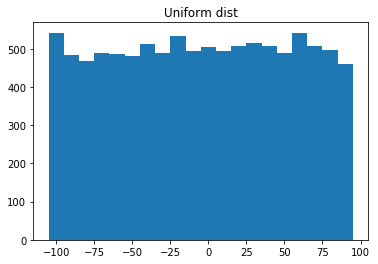

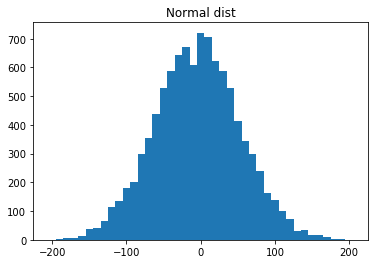

In [2]:
def bucket(point, bucket_size):
    """floor the point to the next lowest multiple of bucket_size"""
    return bucket_size * math.floor(point/ bucket_size)

def make_histogram(points, bucket_size):
    """buckets the points and counts how many in each bucket"""
    return Counter(bucket(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(list(histogram.keys()), list(histogram.values()), width=bucket_size)
    plt.title(title)
    plt.show()
    
# Simple example

random.seed(0)

# Uniform between -100 and 100
uniform = [200*random.random() - 100 for _ in range(10000)]

normal = [57*p.inverse_normal_cdf(random.random())
         for _ in range(10000)]

plot_histogram(uniform, 10, "Uniform dist")

plot_histogram(normal, 10, "Normal dist")

## Two Dimensions
Now imagine you have a dataset with two dimensions. Maybe in addition to daily minutes, you have years of data science experience. Of course, you'd want to understand each dimension individually. But, you'd probably also want to scatter the data. 

For example, consider another faked data set: 

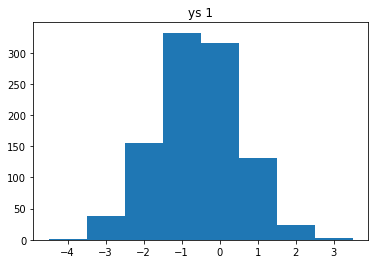

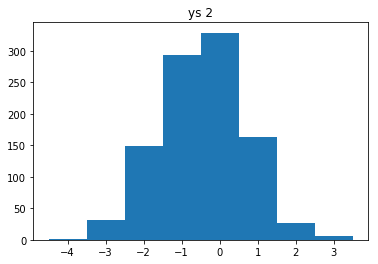

In [3]:
def random_normal():
    """return a random draw from a standard normal distribution"""
    return p.inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]


# Note the similarity- both are normally distributed 
# with the same mean and standard devation
plot_histogram(ys1, 1, "ys 1")
plot_histogram(ys2, 1, "ys 2")


But, each has a very differnt joint distribution with xs:

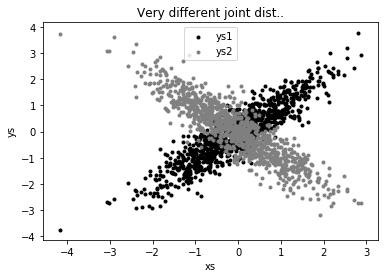

In [4]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel("xs")
plt.ylabel("ys")
plt.legend(loc=9)
plt.title("Very different joint dist..")
plt.show()

The difference would also be evident by looking at the correlations: 

In [5]:

print(s.correlation(xs, ys1))
print(s.correlation(xs, ys2))

0.9010493686379609
-0.8920981526880033


## Many Dimensions
With many dimensions, you'd like to know how all the dimensions relate to one another. A simple approach is to look at the correlation matrix, in which an entry in the $i$th row and $j$th column matrix is the correlation between dimension $i$ and dimension $j$. 

In [6]:
def correlation_matrix(data):
    """returns the num_columns x num_columns matrix whose (i,j)th entry
       is the correlation between columns i and j"""
    
    _, num_columns = l.shape(data)
    
    def matrix_entry(i,j):
        return s.correlation(l.get_column(data, i), l.get_column(data, j))
    
    return l.make_matrix(num_columns, num_columns, matrix_entry)




In [7]:
data = l.make_matrix(500,5, lambda x,y: random_normal())

print(correlation_matrix(data))

[[1.0, -0.026440426298847523, -0.019201033259393024, -0.0034367640365226397, -0.035551614885547575], [-0.02644042629884752, 1.0, 0.0515616187237425, 0.029406822380919503, -0.020389274694135148], [-0.019201033259393024, 0.0515616187237425, 0.9999999999999998, -0.029959753569276774, 0.011211545263621316], [-0.0034367640365226397, 0.0294068223809195, -0.029959753569276777, 1.0, 0.07839396015023675], [-0.035551614885547575, -0.020389274694135148, 0.011211545263621316, 0.07839396015023675, 1.0000000000000002]]


A more visual method is to make a scatterplot matrix, showing all the pairwise scatterplots. To do that, we'll use matplotlib's subplots, which allows us to create subplots of our chart. We give it the number of rows and columns and it returns a $figure$ object (which we won't use) and a two-dimensional array of axes (each of which we'll plot to):

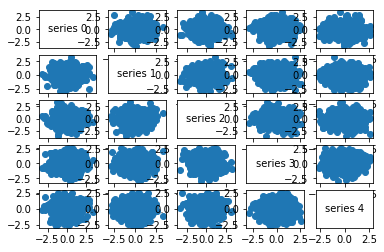

In [8]:
import matplotlib.pyplot as plt

_, num_columns = l.shape(data)
fig, ax = plt.subplots(num_columns, num_columns)

for i in range(num_columns):
    for j in range(num_columns):
        
        # scatter column j on the x-axis vs column i on  the y axis
        if i != j: 
            ax[i][j].scatter(l.get_column(data, j), l.get_column(data, i))
            
        else:
            # unless i == j, in which case, show the series name. 
            ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                             xycoords="axes fraction", 
                             ha="center", va="center")
            
            # then hide the axis lables except the left and bottom charts. 
            if i < num_columns -1:
                ax[i][j].xaxis.set_visible(False)
            if j >0:
                ax[i][j].yaxis.set_visible(False)
                
# fix the bottom right and top left axis lables, which are wrong, 
# because their charts only have text in them. 
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

         
        

## Cleaning and Munging
Data often needs to be cleansed before it can be used. Typically, it's easier to do this as part of the extractionn and process, rather than just before it's used. 
We're going to create a function that wraps csv.reader. We'll give it a list of parsers, each specifying how to parse one of the columns. And we'll use "None" to represent no transformation required to that column. 

In [9]:
def parse_row(input_row, parsers):
    """given a list of parsers (some of which may be None)
    apply the appropriate one to each element of the input row"""
    
    return [parser(value) if parser is not None else value
           for value, parser in zip(input_row, parsers)]

def parse_row_with(reader, parsers):
    """wrap a reader to apply the parsers to each of its rows"""
    for row in reader: 
        yield parse_row(row, parsers)
        
        

What if there's bad data- a "float" that contains a character. We'd rather get a None than crash the program. We can do this with a helper function: 

In [10]:
def try_or_none(f):
    """wraps f to return None if f raises an exception
    assumes f only takes one input"""
    
    def f_or_none(x):
        try: return f(x)
        except: return None
        
    return f_or_none

# Can then rewrite parse_row to use it: 

def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value
           for value, parser in zip(input_row, parsers)]



In [11]:
# now, to use it: 
#

import dateutil.parser
import csv

data = []

with open("Sample_CSV.csv", "r") as f:
    reader = csv.reader(f)
    for line in parse_row_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)
        
print(data)


[[datetime.datetime(2014, 6, 20, 0, 0), 'AAPL', 90.91], [datetime.datetime(2014, 6, 20, 0, 0), 'MSFT', 41.68], [datetime.datetime(3014, 6, 20, 0, 0), 'FB', 64.5], [datetime.datetime(2014, 6, 19, 0, 0), 'AAPL', 91.86], [datetime.datetime(2014, 6, 19, 0, 0), 'MSFT', None], [datetime.datetime(2014, 6, 19, 0, 0), 'FB', 64.34], []]


In [12]:
# Then, just need to check for None rows... 

for row in data:
    if any(x is None for x in row):
        print(row)

[datetime.datetime(2014, 6, 19, 0, 0), 'MSFT', None]


Next step is to decide what to do with the None rows... 

Typically, there are three approaches:
    Fix in source
    Fix in programme 
    Do nothoing and hope
    
We could create similar helpers for csv.DictReader. In that vcase, you'd probably want to supply a dict of parsers by field name, such as: 


In [13]:
def try_parse_field(field_name, value, parser_dict):
    """try to parse value using the appropriate function from parser_dict"""
    parser = parser_dict.get(field_name)   # None if no such entry
    
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value
    
    
def parse_dict(input_dict, parser_dict):
    return { field_name : try_parse_field(field_name, value, parser_dict)
             for field_name, value in input_dict.iteritems() }
    

A good next step is to check for outliers in the data. This can be done using techniques from the earlier sections of this chapter. 

## Manipulating Data
Data manipulation is more of a general approach than a specific technique, so there are just a handful of examples. 
Imagine we're dealing with a set of dicts containing stock price data. Think of them as rows in a spreadsheet. Something like: 

In [14]:
import datetime

data =[
    {'closing_price': 102.06, 
     'date': datetime.datetime( 2014, 8, 29, 0, 0), 
     'symbol': 'AAPL'},
    {'closing_price': 100.00, 
     'date': datetime.datetime( 2014, 8, 28, 0, 0), 
     'symbol': 'AAPL'},    
    
]

Lets start looking at the data. Along the way, we'll try to notice patterns in what we're doing and abstract out some tools that may help. 

For instance, suppose we want to know the highest ever closing price for AAPL. Think about the steps: 
1. restrict ourselves to AAPL reows. 
2. Grab the closing price from each row. 
3. Take the max of those prices. 

This can be done using list comprehension:

In [15]:
max_aapl_price = max(row["closing_price"]
                    for row in data
                    if row["symbol"] == "AAPL")

print(max_aapl_price)

102.06


More generally, we may want to know the highest-ever closing price for each stock in our data set. One way to do this is: 

1. Group together all the rows with the same symbol. 
2. Within each group, do the same as before: 


In [16]:
from collections import defaultdict

# group by symbol
by_symbol = defaultdict(list)
for row in data:
    by_symbol[row["symbol"]].append(row)
    
# use a dict comprehension to find the max for each closing price. 
max_price_by_symbol = { symbol : max(row["closing_price"]
                                     for row in grouped_rows)
                        for symbol, grouped_rows in by_symbol.items() }
                                     
print(max_price_by_symbol)

{'AAPL': 102.06}


There are some patterns here already. In both examples, we need to pull the closing price value out of every dict. So let's create a pick function to select a field from a dict, and another to pluck the same field from a collection of dicts:

In [17]:

def picker(field_name):
    """returns a function that picks a field out of a dict"""
    return lambda row: row[field_name]

def pluck(field_name, rows):
    """turn a list of dicts into the list of field_name values"""
    return map(picker(field_name), rows)


We can also create functions to group rows by the result of a grouper function and to optionally apply some sort of value transformation to each group:

In [18]:
def group_by(grouper, rows, value_transformation=None):
    # key is output of grouper, value is list of rows:
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
        
    if value_transformation is None:
        return grouped
    else:
        return {key : value_transformation(rows)
                   for key, value in grouped.items() }

In [19]:
# We can then rewrite the previous examples quite simply 

max_price_by_symbol = group_by(picker("symbol"),
                              data,
                              lambda rows : max(pluck("closing_price", rows)))

print(max_price_by_symbol)

{'AAPL': 102.06}


We can now start to build on this, to do more complicated things, like largest and smallest one-day percentage changes in our data. The percentage change is price_today / price_yesterday - 1, which means we need some way of associating today's price and yesterday's price. One approach is to group the prices by symbol, then, within each group: 

1. Order the prices by date. 
2. Use zip to get pairs (previous, current)
3. Turn the pairs into new "percentage change" rows. 

We'll start by writing a function to do all the within-group work: 

In [20]:
def percent_price_change(yesterday, today):
    return today["closing_price"] / yesterday["closing_price"] - 1

def day_over_day_changes(grouped_rows):
    # sort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))
    
    # zip with an offset to get pairs of consecutive days
    return [{"symbol" : today["symbol"],
            "date" : today["date"],
            "change" : percent_price_change(yesterday, today)}
               for yesterday, today in zip(ordered, ordered[1:])]


In [21]:
# Then, we can just use this as the value_transform in a group_by:

# key is a symbol, value is list of "change" dicts
changes_by_symbol = group_by(picker("symbol"), data, day_over_day_changes)

print(changes_by_symbol)

all_changes = [change
              for changes in changes_by_symbol.values()
              for change in changes]

print(all_changes)

{'AAPL': [{'symbol': 'AAPL', 'date': datetime.datetime(2014, 8, 29, 0, 0), 'change': 0.02059999999999995}]}
[{'symbol': 'AAPL', 'date': datetime.datetime(2014, 8, 29, 0, 0), 'change': 0.02059999999999995}]


In [22]:
# At which point, it's easy to find the largest and the smallest... 
print(max(all_changes, key=picker("change")))

print(min(all_changes, key=picker("change")))

{'symbol': 'AAPL', 'date': datetime.datetime(2014, 8, 29, 0, 0), 'change': 0.02059999999999995}
{'symbol': 'AAPL', 'date': datetime.datetime(2014, 8, 29, 0, 0), 'change': 0.02059999999999995}


We can now use this new all_changes data set to find which month is the best to invest in tech stocks. First we group the changes by month, then we compute the overall change within each group. 
Once again, we write an appropriate value_transformation and then use group_by:



In [23]:
from functools import reduce

# to combine percent changes, we add one to each, multiply them, then subtract 1. 
# for instance, if we combine +10% and -20%, the overall change is: 
#    (1+10%) * (1-20%) -1 = 1.1 * 0.8 -1 = =12%. 
def combine_pct_changes(pct_change1, pct_change2):
    return (1 + pct_change1) * (1 + pct_change2) - 1

def overall_change(changes):
    return reduce(combine_pct_changes, pluck("change", changes))

overall_change_by_month = group_by(lambda row : row["date"].month,
                                  all_changes,
                                  overall_change)

print(overall_change_by_month)

{8: 0.02059999999999995}


# Rescaling

Many techniques are sensitive to the scale of the data. For example, consider the heights and weights of hundreds of people. Imagine you're trying to identify clusters of body size. 

Intuitively, we'd like clusters to represnt points near each other, which means we need some notion of distance between points. We already have an Euclidean $distance$ function, so a natural approach might bet to treat $(height, weight$ as points in two-dimensional space. Consider the people listed below. 

Person   Height (inches)      Height CM    Weight

A              63                 160          150

B              67                 170.2        160

C              70                 177.8        171

If we measure height in inches, the B's nearest neighbour is A: 

In [24]:
print(l.distance([63,150], [67, 160]))   # A to B
print(l.distance([63,150], [70,171]))   # A to C
print(l.distance([67, 160], [70, 171])) # C to B

10.770329614269007
22.135943621178654
11.40175425099138


In [25]:
# However, measuring height in CM changes B's nearest neighbour. 
print(l.distance([160,150], [170.2, 160]))   # A to B
print(l.distance([160,150], [177.8,171]))   # A to C
print(l.distance([170.2, 160], [177.8, 171])) # C to B

14.284257068535268
27.52889391167034
13.370115930686627


Chaning units is casuing this issue. When dimensions aren't comparable with one another, we'll sometimes rescale the data such that each dimension has mean 0 anf standard deviation 1. This effectively eliminates the units, converting each unit to "standard deviation from the mean".

To start with, we'll need to compute the mean and standard deviation for each column:

In [26]:
def scale(data_matrix):
    """returns the mean and standard deviation of each column"""
    num_rows, num_columns = shape(data_matrix)
    means = [mean(get_column(data_matrix,j))
            for j in range(num_columns)]
    
    std_devs = [standard_deviation(get_column(data_matrix,j))
               for j in range(num_cols)]
    
    return means, std_devs

# then rescale to create a new matrix... 

def rescale(data_matrix):
    """rescales the input data so that each column 
    has mean 0 and standard deviation 1
    leaves alone columns with no deviation """
    means, stdevs = scale(data_matrix)
    
    def rescales(i,j):
        if stddev[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]
        
    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)


## Dimensionality Reduction
Sometimes, the "actual" or useful dimensions of the data might not correspond to the dimensions we have. 
[example- most of the variation in the data seems to be along a trend line through the x and y axis.]

When this is the case, we can use a technique called *principal component analysis* to extract one or more dimensions that capture as much of the variance as possible. 
Note- wouldn't use it on low-dimension data set. Most useful when data has many dimensions and you want to find a subset that captures most of the variance. 

As a first step, we'll need to translate each dimension so that each dimension hs mean zero: a

In [27]:
def de_mean_matrix(A):
    """returns the result of subtracting from every value in A 
    the mean value of its column. The resulting matrix 
    has mean 0 in every column. """
    nr, nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr, nc, lambda i,j: A[i][j] - column_means[j])

# If we don't do this, the techniques are likely to identify the 
# mean value itself, not the varianbce in the data. 

Now, given a de-meaned matrix $X$, we can ask which is the direction that captures the greatest variance in the data? 

Specifically, given a direction *d*(a vector of magnitude 1), each row *x* in the matrix extends $dot(x, d)$ in the $d$ direction. And every nonzero vector $w$ determines a direction if we rescale it to have magnitude 1: 

In [30]:
def direction(w):
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

# Therefore, given a nonzero vector w, we can 
# compute the variance of our dataet in the direction determined by w. 

def directional_variance_i(x_i, w):
    """the variance of the row x_i in the direction determines by w"""
    return l.dot(x_i, direction(w)) ** 2

def directional_variance(X, w):
    """the variance of the data in the direction determined by w"""
    return sum(directional_variance_i(x_i, w)
              for x_i in X)

# We'd like to find the direction that maximises this variance. We can do 
# this using gradient descent, as soon as we have the gradient function: 

def directional_variance_gradient_I(x_i, w):
    """the contribution of row x_i to the gradient of the direction-w
    variance"""
    projection_length = l.dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    return l.vector_sum(directional_variance_gradient_i(x_i, w)
                     for x_i in X)

# The first principle component is just the direction that maximises 
# the directional variance function: 

def first_principle_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximiser = maximise_batch(
        partial(directional_variance, X),    # is now a function of w
        partial(directional_variance_gradient, X), # is now a function of w
    guess)
    
    return direction(unscaled_maximiser)

# Or, if you'd rather use stochastic gradient descent: 
def first_principal_component_sgd(X):
    guess = [1 for _ in X[0]]
    unscaled_maximiser = maximise_stochastic(
        lambda x, _, w: directional_variance_i(x, w),
        lambda x, _, w: directional_variance_gradient_i(x,w),
        X,
        [None for _ in X],    # the fake Y
        guess
    )
    return direction(unscaled_maximiser)


# Once we've found the direction that's the first principle component, 
# we can project our data on to it to find the values of that component. 

def project(v, w):
    """return the projection of v onto the direction w"""
    projection_length = dot(v, w)
    return l.scalar_multiply(projection_length, w)

# If we want to find further components, we first remove the 
# projections from the data:

def remove_projections_from_vector(v, w):
    """projects v onto w and subtracts the result from v"""
    return l.vector_subtract(v, project(v,w))

def remove_projection(X, w):
    """for each row of X, project the row on to w and subtract
        the result from the row"""
    return [remove_projection_from_vector(x_i, w) for x_i in X]

# At this point, we can find the next principal component by 
# repeating the process on the result of remove_projection

# On a higher dimension data set, we can interatively find as many 
# components as we want:

def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)
        
    return components

# We can then transform our data into the lower dimensional space spanned by
# the components: 

def transform_vector(v, components):
    return [l.dot(v,w) for v in components]

def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]



This technique is valuable for a couple of reasons. First, it can help to clean our data by eliminating noise dimensions and consolidating dimensions that are highly correlated. 
Second, after extracting a low-dimensional representation of our data. we can use a variety of techniques that don't work well on high-dimensional data. We'll see examples of this later. 
However, although it can make models easier to build, it can also make models more difficult to interprit. For example, it's easy to understand conclusions like "every extra year of experience adds an average of \$10k in salary". It's harder to understand something like "every 0.1 increae in the third principal component adds an average of \$10k in salary". 